In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn import metrics
import math

#import stuff for gradCAM
import matplotlib.cm as cm
from IPython.display import Image

#Set GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.3.2


In [2]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [3]:
# define a callback

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 30, 
                                             restore_best_weights = True)

In [4]:
#build data generators for training and validaton

split = 0.2

total_train = 2001
total_val = 499


# Define dirs and files
train_data_dir = '../data/pics/labelertoModel/AllRoundsFive'

# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(rescale =1./255.,
                                   rotation_range = 90,
                                   width_shift_range = 0.5,
                                   height_shift_range = 0.5,
                                   shear_range = 0.45,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)


#set batch Size
batch_size = 16

#set Image size (RGB so imshape is 3)
pix_dim = 512
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    target_size = imsize,
                                                    subset='training')

# Flow validation images in batches 
validation_generator =  train_datagen.flow_from_directory(train_data_dir, # same directory as training data,
                                                        batch_size = batch_size,
                                                        class_mode = 'binary',
                                                        target_size = imsize,
                                                        subset='validation')

Found 2001 images belonging to 2 classes.
Found 499 images belonging to 2 classes.


In [5]:
# define the metrics
acc_metric = tf.keras.metrics.BinaryAccuracy(name='acc')

In [6]:
#load or build model
##########

#from scratch:
#base model, no top layer, w/ imagenet weights
base_model = tf.keras.applications.VGG16(input_shape = imshape, 
                                             include_top = False, 
                                             weights = 'imagenet')

base_model.trainable = True
# add a new classifcation layer

final_layer = base_model.get_layer('block5_pool')
print('shape of last layer is ', final_layer.output_shape)
final_base_output = final_layer.output


#add the last layer
# Flatten the output layer to 1 dimension
x = layers.Flatten()(final_base_output )
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-4))(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(base_model.input, x) 
#############
model.summary()

shape of last layer is  (None, 16, 16, 512)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_poo

In [7]:
#build the model
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr = 1e-5),
              metrics = acc_metric)

In [8]:
#train the model
history = model.fit(train_generator,
                    steps_per_epoch = total_train // batch_size,
                    validation_data = validation_generator,
                    epochs= 140,
                    validation_steps =  total_val // batch_size,
                    callbacks =[callbacks])

Epoch 1/140
125/125 [==============================] - 436s 3s/step - loss: 0.9075 - acc: 0.5128 - val_loss: 0.8329 - val_acc: 0.5000
Epoch 2/140
125/125 [==============================] - 432s 3s/step - loss: 0.8020 - acc: 0.5275 - val_loss: 0.7707 - val_acc: 0.5403
Epoch 3/140
125/125 [==============================] - 428s 3s/step - loss: 0.7508 - acc: 0.5264 - val_loss: 0.7245 - val_acc: 0.5423
Epoch 4/140
125/125 [==============================] - 432s 3s/step - loss: 0.7115 - acc: 0.5582 - val_loss: 0.7120 - val_acc: 0.5605
Epoch 5/140
125/125 [==============================] - 422s 3s/step - loss: 0.6926 - acc: 0.5572 - val_loss: 0.6917 - val_acc: 0.5423
Epoch 6/140
125/125 [==============================] - 430s 3s/step - loss: 0.6753 - acc: 0.5869 - val_loss: 0.6940 - val_acc: 0.5645
Epoch 7/140
125/125 [==============================] - 428s 3s/step - loss: 0.6432 - acc: 0.6438 - val_loss: 0.6646 - val_acc: 0.6190
Epoch 8/140
125/125 [==============================] - 418s 3s

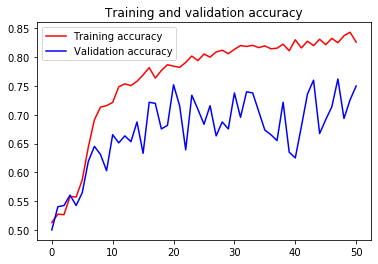

<Figure size 432x288 with 0 Axes>

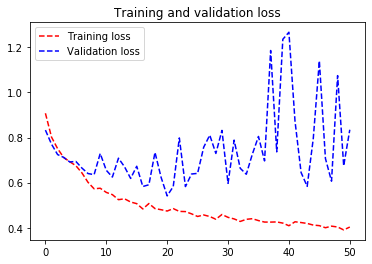

<Figure size 432x288 with 0 Axes>

In [9]:
#look at the metrics from training
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

In [10]:
#save the model
filepath = './models/VGG16_model_5_8020split_512px'
model.save(filepath)

#load model
#model = tf.keras.models.load_model(filepath, compile = True)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/VGG16_model_5_8020split_512px/assets
